In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table
from astropy.io import fits

from ekfplot import plot as ek

from agrias import utils
import reader

In [90]:
merian = table.Table(fits.getdata('/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v1.2.fits',1))
ms = reader.merianselect ( merian )
_galex = reader.galexcrossmatch ()
overlap = ms.index.intersection(_galex.index)

merian_sources = ms.reindex(overlap)

_galex = _galex.sort_values('fuv_exptime', ascending=False)

galex = _galex.loc[~_galex.index.duplicated(keep='first')].reindex(overlap).reset_index()

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0


/Users/kadofong/work/projects/merian/agrias/notebooks/reader.py:48: RuntimeWarning: overflow encountered in power
  mertab['AV'] = av


[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [91]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)

In [92]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
lha_df = lha_df.reindex(merian_sources.index)
print(lha_df.dropna().shape)

(14163, 4)


In [108]:
np.log10(catalog_snr/direct_snr).median()e

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.199294332654127

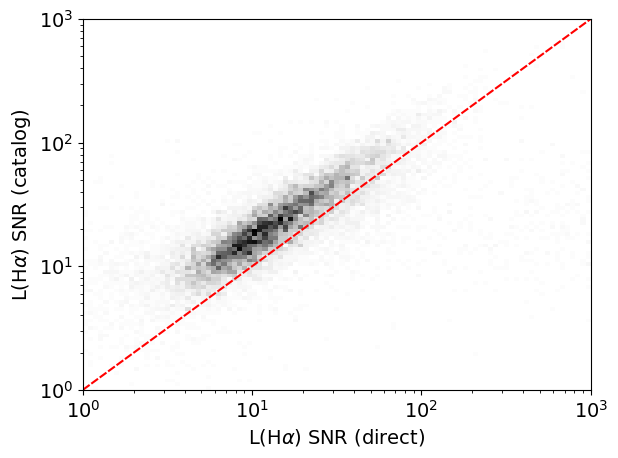

In [110]:
direct_snr = (lha_df['LHa']/lha_df['u_LHa']).reindex(catalog_halum.index)
catalog_snr = catalog_halum['LHa']/catalog_halum['u_LHa']
ek.hist2d(
    direct_snr,
    catalog_snr,
    bins=np.logspace(0, 3,100)
)
xs = np.logspace(0,3,100)
plt.plot(xs,xs,color='r', dashes = [4,1])
ek.loglog()
plt.xlabel(r'L(H$\alpha$) SNR (direct)')
plt.ylabel(r'L(H$\alpha$) SNR (catalog)')
plt.tight_layout ()
plt.savefig('/Users/kadofong/Desktop/direct_v_catalog_snr.png')

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


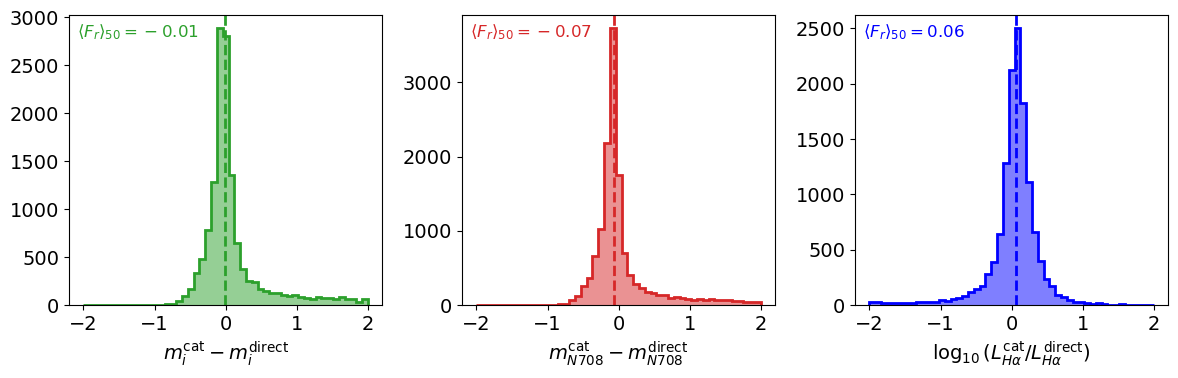

In [93]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
catalog_apercorr = merian_sources['i_cModelFlux_Merian'] / merian_sources['i_gaap1p0Flux_Merian']
f2m = lambda x, zp = 31.4: -2.5*np.log10(x*catalog_apercorr) + zp
ratios = [
    merian_sources['i_cModelmag_Merian'] - lha_df.reindex(merian_sources.index)['imag'],
    f2m(merian_sources['N708_gaap1p0Flux_Merian']) - lha_df.reindex(merian_sources.index)['n708mag'],    
    np.log10(catalog_halum['LHa']/1e40/lha_df.reindex(catalog_halum.index)['LHa']),
    #np.log10(calibrations.SFR2LHa(10.**merian_sources['logsfr_gaap1p0']) / (lha_df['LHa']*1e40) )
]
colorlist = [
    'tab:green',
    'tab:red',
    'b'
]
labels = [
    r'$m_i^{\rm cat} - m_i^{\rm direct}$',
    r'$m_{N708}^{\rm cat} - m_{N708}^{\rm direct}$',
    r'$\log_{10}(L_{H\alpha}^{\rm cat}/L_{H\alpha}^{\rm direct})$'
]

for idx, ax in enumerate(axarr):
    ek.hist( 
        ratios[idx],
        bins=np.linspace(-2.,2.,50),
        ax=axarr[idx],
        color=colorlist[idx],
        alpha=0.5,
        lw=2
    )    
    axarr[idx].axvline(
        np.nanmedian(ratios[idx]),
        color=colorlist[idx],
        lw=2,
        ls='--'
    )
    ek.text(
        0.025,
        0.975,        
        r'$\langle F_r \rangle_{50} = %.2f$' % np.nanmedian(ratios[idx]),
        ax=axarr[idx],
        color=colorlist[idx],
        fontsize=12
    )
    axarr[idx].set_xlabel(labels[idx])   
plt.tight_layout ()
plt.savefig('../../../sfr_calibrators/figures/data_validation/photometric_offsets.png')

In [63]:
from ekfphys import calibrations, observer
from ekfparse import query

In [64]:
rv = 3.1
ge_av = merian_sources['ebv_Merian']*rv

In [65]:
gecorr = np.zeros([len(ge_av),2])
for idx,row in enumerate(ge_av.values):
    gecorr[idx] = -observer.gecorrection(np.array([4758.71,6135.]), row, return_magcorr=True)


In [66]:
ref = np.genfromtxt('/Users/kadofong/Desktop/ref.txt')

Text(0, 0.5, 'g-r')

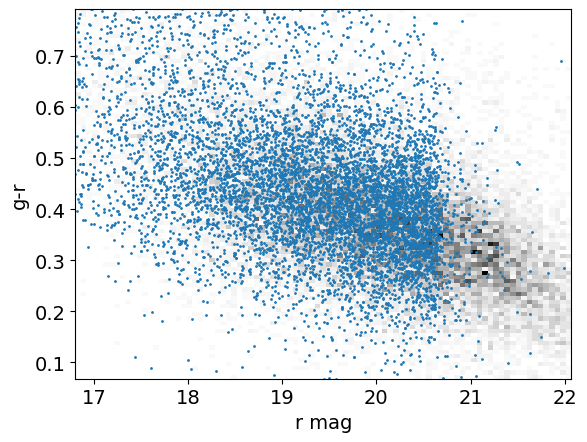

In [67]:
apercorr = merian_sources['i_cModelFlux_Merian']/merian_sources['i_gaap1p0Flux_Merian']
flux = merian_sources.loc[:,utils.photcols['r']]*apercorr
gr = -2.5*np.log10(merian_sources[utils.photcols['g']]/merian_sources[utils.photcols['r']]) + gecorr[:,0] - gecorr[:,1]
merian_rmag = -2.5*np.log10(flux) + 31.4

_=ek.hist2d(
    merian_rmag,
    gr,
    bins=90, 
)
plt.scatter(
    ref[3],
    ref[2]-ref[3],
    s=1,
)
#plt.xlim(7., 11.2)
plt.xlabel('r mag')
plt.ylabel('g-r')

In [68]:
lee = table.Table.read('/Users/kadofong/work/projects/literature_ref/lee2009/tab1_processed.txt', format='mrt')
leer = lee['loghalum'] - lee['loguvlum']

In [69]:
ll = ''
dirstem = '/scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/'
for band in 'grizy':
    for tp in ['image','psf']:
        if tp=='psf':
            suffix='_psf'
        else:
            suffix=''
        print(f'mv {dirstem}J*{band}{suffix}.fits {dirstem}hsc_{band}/{tp}/')
print(ll)

mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*g.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_g/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*g_psf.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_g/psf/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*r.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_r/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*r_psf.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_r/psf/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*i.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_i/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*i_psf.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_i/psf/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*z.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_z/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*z_psf.fits /scratch

In [81]:
merr

M3324835201464449405          NaN
M3324848395603966290         -inf
M3324852793650467962         -inf
M3324857191696979637    12.642536
M3324865987790013450    13.263909
                          ...    
M3339216813555746526    12.674131
M3339256395974337725    14.747660
M3339291580346429638    13.076972
M3339291580346429639    12.926735
M3339291580346444953    12.981179
Length: 17378, dtype: float64

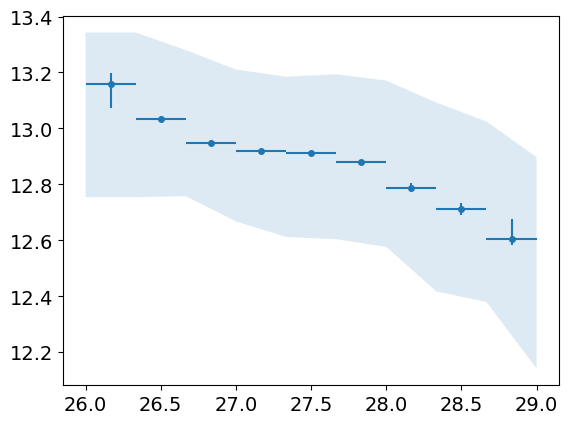

In [86]:
merr = np.log10(lha_df['LHa']*1e40 / catalog_halum.reindex(lha_df.index)['LFUV'])
merr = np.where(np.isfinite(merr),merr, np.NaN)


(12.0, 14.0)

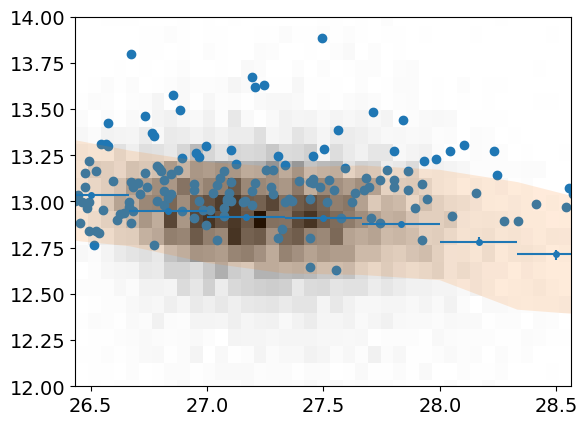

In [87]:

#plt.axvline(np.nanmedian(leer), lw=3, dashes=[7,1])
ek.hist2d(
    np.log10(catalog_halum.reindex(lha_df.index)['LFUV']),
    merr,
    density=True,
    bins=40,
)
out=plt.scatter(
    lee['loguvlum'],
    leer,
    #bins=20,
)
_=ek.running_quantile(
    np.log10(catalog_halum.reindex(lha_df.index)['LFUV']),
    merr,
    np.linspace(26.,29.,10),
    erronqt=True
)

plt.axvline(np.nanmedian(merr), lw=3, color='C1', dashes=[7,1])
plt.ylim(12.,14.)